In [1]:
import cdms2 as cdms
import MV2 as MV
import cdtime,cdutil,genutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import string
import glob
import scipy.stats as stats
# Local solution
# If running remotely, uncomment the following code:
# %%bash
# git clone https://github.com/katemarvel/CMIP5_tools
# import CMIP5_tools as cmip5
import sys,os
sys.path.append("../python-utils")

import CMIP5_tools as cmip5
import DA_tools
import Plotting
import cartopy_plot

# cartopy stuff
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry.polygon import LinearRing
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.io.shapereader as shpreader

from eofs.cdms import Eof
from eofs.multivariate.cdms import MultivariateEof
%matplotlib inline
import matplotlib.mlab as mlab

rootdirec="/home/kdm2144/"
#Define the region

import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("paper")

# Time and Space
Use these to set desired spatial and time domain

In [2]:
India=cdutil.region.domain(longitude=(68,98),latitude=(5,38))
start_date='1979-1-1'
stop_date='2014-12-31'

# Helper functions
Functions to plot data, mask land, and extract JJA precipitation over S Asia

In [3]:
def meshplot_SAsia(mme_diff,cmap_name=plt.cm.BrBG,vmax=None,vmin=None,\
                   only_India=False,clevs=None,nrow=1,ncol=1,axnum=1,figsize=(12,12)):
    lono=mme_diff.getLongitude()[:]
    lato=mme_diff.getLatitude()[:]
    lon,lat=np.meshgrid(lono,lato)
    states_provinces = cfeature.NaturalEarthFeature(category='cultural',\
            name='admin_1_states_provinces_lines',\
            scale='50m',\
            facecolor='none')
    extent_lonlat = (68, 98, 5, 38)

    #clevs = np.array([-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,.3,.4,.5,.6])*2.5
    
    p5=np.percentile(mme_diff.compressed(),5)
    p95=np.percentile(mme_diff.compressed(),95)
    if vmin is None:
        vmin=-1*max(np.abs(p5),np.abs(p95))
    if vmax is None:
        vmax=max(np.abs(p5),np.abs(p95))
    if clevs is None:
        clevs=np.linspace(vmin,vmax,13)
        
    clevs_units=clevs.copy()
    nmap = plt.cm.get_cmap(name=cmap_name,lut=clevs.size-1)

    ocean_color = np.float64([209,230,241])/255

    fig = plt.figure(figsize=figsize,facecolor="white")
    ax = fig.add_subplot(nrow, ncol, axnum, projection=ccrs.Orthographic(central_longitude=80, central_latitude=25, globe=None))
    m = ax.contourf(lon, lat, mme_diff,clevs,transform=ccrs.PlateCarree(),cmap=nmap,extend="both")
    #m = ax.pcolormesh(lon, lat, mme_diff,vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree(),cmap=nmap)
    ax.coastlines()
    ax.set_global()
    ax.set_extent(extent_lonlat, crs=ccrs.PlateCarree())
    #ax.gridlines(xlocs=np.arange(-180,190,10),ylocs=np.arange(-180,190,10))
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='-', edgecolor='k')
    ax.add_feature(states_provinces, linewidth=0.5, linestyle='-', edgecolor='k')
    #ax.add_feature(newcoast, linewidth=0.5, linestyle='-', edgecolor='k')
    #ax.add_feature(newlake, linewidth=0.5, linestyle='-', edgecolor='k')
    ax.add_feature(cartopy.feature.LAND,color='white',zorder=0,edgecolor='k',hatch="/")
    ax.add_feature(cartopy.feature.OCEAN,color=ocean_color,zorder=0,edgecolor='k')
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='-', edgecolor='k')
    ax.add_feature(cartopy.feature.OCEAN,color=ocean_color,zorder=1)
    
    #ax.add_feature(newcoast, linewidth=1, linestyle='-', zorder=2,edgecolor='k')
    #ax.text(-122,21,var_txt+' ('+seas_txt+')',transform=ccrs.PlateCarree(),fontsize=32,fontweight="bold", \
     #horizontalalignment='center', verticalalignment='center',)
    #ax.text(-122,17,ssp_txt,transform=ccrs.PlateCarree(),fontsize=28,fontweight="normal", \
     #horizontalalignment='center', verticalalignment='center',)
    #cbar=plt.colorbar(m,orientation="horizontal",fraction=0.08,pad=0.04)#,ticks=clevs_units[np.arange(0,clevs_units.size+1,2)])
    if ((vmin ==0 ) and (vmax==365)):
        cbar=plt.colorbar(m,orientation="horizontal",fraction=0.08,pad=0.04,ticks=np.linspace(0,365,12))
        cbar.ax.set_xticklabels(["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"])
    else:
        #cbar=plt.colorbar(m,orientation="horizontal",fraction=0.08,pad=0.04)
        plt.colorbar(m,ax=[ax],fraction=0.08,pad=0.04,location="left")
    #cbar.ax.tick_params(labelsize=24)
    
    shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
    reader = shpreader.Reader(shpfilename)
    countries = reader.records()
    if only_India:
        for country in countries:
            if country.attributes["NAME"] != "India":
                ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                                  facecolor="w",)

        #ax.add_feature(cartopy.feature.RIVERS,color=ocean_color,zorder=2)
    return fig



def mask_data(data,basicmask):
    dim = len(data.shape)
    if dim == 2:
        mask= basicmask
    elif dim ==3:
        nt = data.shape[0]
        mask= np.repeat(basicmask[np.newaxis,:,:],nt,axis=0)
    elif dim ==4:
        nmod,nt,nx,ny = data.shape
        mask= np.repeat(np.repeat(basicmask[np.newaxis,:,:],nt,axis=0)[np.newaxis],nmod,axis=0)
    return MV.masked_where(mask,data)


def monsoonify(data,mask_ocean=True):
    #restrict the spatial domain to S Asia
    regional_data=data(India)
    if mask_ocean:
        #mask out the ocean
        fl=cdms.open("/home/kdm2144/DROUGHT/fixedvar/sftlf_fx_"+model+".nc")
        landfrac=fl("sftlf")(India)/100.
        landmask=landfrac.asma()==0
        masked_data=mask_data(regional_data,landmask)
    else:
        masked_data=regional_data
    #JJA only
    cdutil.setTimeBoundsMonthly(masked_data)
    return cdutil.JJA(masked_data)
    

# Load the data
Load CESM2 historical and pre-industrial control ensembles, along with GPCP and CMAP observational datasets

In [4]:
#Load the historical ensemble
model="CESM2"
variable="pr"
rawdir="/home/kdm2144/DROUGHT/DOWNLOADED_RAW/pr/"
rips=np.unique([x.split(".")[-3] for x in glob.glob(rawdir+model+"/*historical*")])
nrips=len(rips)
#get shape
f=cdms.open(glob.glob(rawdir+model+"/"+variable+".historical."+model+"."+rips[0]+".*")[0])

gridsize=(f[variable].shape)[1:]

f.close()
historical=MV.zeros((nrips,165*12)+gridsize)

for ripi in range(len(rips)):
    rip=rips[ripi]
    fnames=sorted(glob.glob(rawdir+model+"/"+variable+".historical."+model+"."+rip+".*"))
    for timei in range(len(fnames)):
        f=cdms.open(fnames[timei])
        data=f(variable)*60*60*24
        historical[ripi,12*timei:12*(timei+1)]=data
        f.close()
  
  

modax=cmip5.make_model_axis(rips)
tax=cdms.createAxis(np.arange(165*12))
tax.designateTime()
tax.id="time"
tax.units="months since 1850-1-1"
latax=data.getLatitude()
lonax=data.getLongitude()
axlist=[modax,tax,latax,lonax]
historical.setAxisList(axlist)
historical.id=variable
cdutil.setTimeBoundsMonthly(historical)

#Load the ssp ensemble
model="CESM2"
variable="pr"
rawdir="/home/kdm2144/DROUGHT/DOWNLOADED_RAW/pr/"
rips=np.unique([x.split(".")[-3] for x in glob.glob(rawdir+model+"/*ssp585*")])
nrips=len(rips)
#get shape
f=cdms.open(glob.glob(rawdir+model+"/"+variable+".ssp585."+model+"."+rips[0]+".*")[0])

gridsize=(f[variable].shape)[1:]

f.close()
ssp585=MV.zeros((nrips,86*12)+gridsize)

for ripi in range(len(rips)):
    rip=rips[ripi]
    fnames=sorted(glob.glob(rawdir+model+"/"+variable+".ssp585."+model+"."+rip+".*"))
    for timei in range(len(fnames)):
        f=cdms.open(fnames[timei])
        data=f(variable)*60*60*24
        ssp585[ripi,12*timei:12*(timei+1)]=data
        f.close()
  
  

modax=cmip5.make_model_axis(rips)
tax=cdms.createAxis(np.arange(86*12))
tax.designateTime()
tax.id="time"
tax.units="months since 2015-1-1"
latax=data.getLatitude()
lonax=data.getLongitude()
axlist=[modax,tax,latax,lonax]
ssp585.setAxisList(axlist)
ssp585.id=variable
cdutil.setTimeBoundsMonthly(ssp585)

#Load the piControl simulatioh
model = "CESM2"
allpiC=glob.glob(rawdir+model+"/*.piControl"+".*")
rip=sorted(np.unique([x.split(".")[3] for x in allpiC]))[0]
piCs=sorted(glob.glob(rawdir+model+"/*.piControl."+model+"."+rip+"*"))
L=len(piCs)
fname=piCs[0]
f=cdms.open(fname)
piC=f("pr")(India)
f.close()

for fname in piCs:
    f=cdms.open(fname)
    datai=f("pr")(India)*60*60*24
    piC=MV.concatenate((piC,datai))
    f.close()
cdutil.setTimeBoundsMonthly(piC)

#Load the observations
f=cdms.open("OBS/GPCP.mon.mean.nc")
tmp=f('precip')
f.close()
gpcp=tmp.regrid(historical.getGrid(),regridTool='regrid2')



fc=cdms.open("OBS/CMAP.precip.mon.mean.nc")
tmpc=fc('precip')
fc.close()
cmap=tmpc.regrid(historical.getGrid(),regridTool='regrid2')



/home/kdm2144/miniconda3/envs/cdatpy3scipy/lib/python3.6/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]


# Calculate monsoon indices
Extract JJA precipitation averages over South Asia from model and observational data

In [5]:
jja_historical=monsoonify(historical)
jja_piC=monsoonify(piC[12:])
jja_ssp585=monsoonify(ssp585)
jja_cmap=monsoonify(cmap)
jja_gpcp=monsoonify(gpcp)

/home/kdm2144/miniconda3/envs/cdatpy3scipy/lib/python3.6/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


# EOF decompositions
What are the EOFs for the 11-member ensemble average of CESM2 historical runs?  How much of the variance do they explain?

In [13]:
ensav=MV.average(cdutil.JJA.departures(jja_historical),axis=0)
solver=Eof(ensav(time=(start_date,stop_date)))
#solver=Eof(ensav)
solver_piC=Eof(cdutil.JJA.departures(jja_piC))
solver_facs=np.sign(cmip5.get_linear_trends(solver.pcs()))
print("EOFS 1, 2, 3 explain ",solver.varianceFraction()[:3])

EOFS 1, 2, 3 explain  [0.32034184 0.13311359 0.12692946]


# EOF 1
The leading EOF is characterized by wetting in the IGP, Central India, and the west coast.  The associated PC shows an upward trend, indicating that it is more strongly expressed in the ensemble average as time goes on.  I don't know what's happening with the dip in 2010.  This could just be natural variability- this is an advantage to having a large sample size like the CESM2 LENS to beat down climate moise.  I can't think of what else it could be, unless CESM2 is having a big monsoon response to the Eyjafjallajökull eruption.

/home/kdm2144/miniconda3/envs/cdatpy3scipy/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/home/kdm2144/miniconda3/envs/cdatpy3scipy/lib/python3.6/site-packages/matplotlib/tight_layout.py:181: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. '


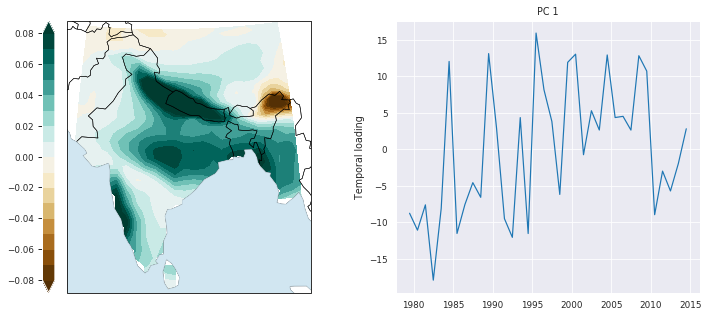

In [14]:
eof_number=0
fig=meshplot_SAsia(solver_facs[eof_number]*solver.eofs()[eof_number],nrow=1,ncol=2,axnum=1,figsize=(12,5),
                  clevs=np.arange(-0.08,0.09,.01))
ax2=fig.add_subplot(1,2,2)
Plotting.time_plot(solver_facs[eof_number]*solver.pcs()[:,eof_number],ax=ax2)
ax2.set_title("PC "+str(eof_number+1))
plt.ylabel("Temporal loading")
plt.tight_layout()

# EOF 2
This is the second EOF, characterized by drying in the central east, wetting in the south, wetting over the himalayas.  PC also trends upward.  Keep in mind that EOF decomposition is not a good way to identify the fingerprints of distinct forcings, which may or may not be orthogonal to each other.

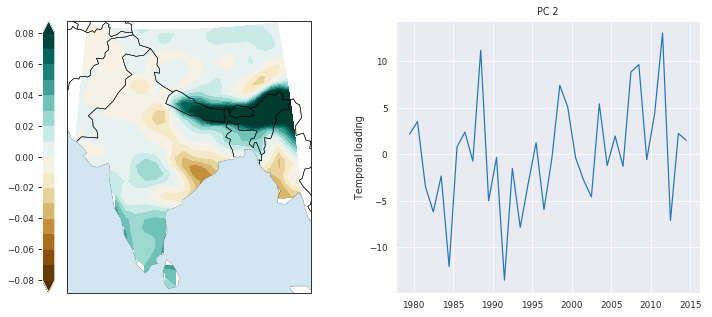

In [18]:
eof_number=1
fig=meshplot_SAsia(solver_facs[eof_number]*solver.eofs()[eof_number],nrow=1,ncol=2,axnum=1,figsize=(12,5),
                  clevs=np.arange(-0.08,0.09,.01))
ax2=fig.add_subplot(1,2,2)
Plotting.time_plot(solver_facs[eof_number]*solver.pcs()[:,eof_number],ax=ax2)
ax2.set_title("PC "+str(eof_number+1))
plt.ylabel("Temporal loading")
plt.tight_layout()

# Signal-to-noise analysis
Signal: regress observations on PC1
Noise: regress chunks of piControl on PC1
Attribution: regress historical ensemble members on PC1

EOF1 is not very strongly expressed in the observations, which are compatible with the noise estimates.  The observational signals are incompatible with the historical simulations

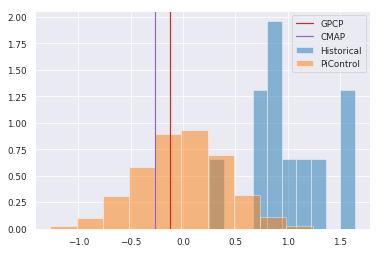

In [24]:
#project the historical ensemble members on the fingerprint
eof_number=0

pc1=solver.pcs()[:,eof_number](time=(start_date,stop_date))

#Project observations: 
#GPCP
proj_gpcp=solver.projectField(cdutil.JJA.departures(jja_gpcp(time=(start_date,stop_date))))[:,eof_number]
gpcp_coeff=float(genutil.statistics.linearregression(proj_gpcp,x=pc1)[0])

#CMAP
proj_cmap=solver.projectField(cdutil.JJA.departures(jja_cmap(time=(start_date,stop_date))))[:,eof_number]
cmap_coeff=float(genutil.statistics.linearregression(proj_cmap,x=pc1)[0])

nt=proj_gpcp.shape[0]

historical_anomalies=cdutil.JJA.departures(jja_historical)
historical_projections=[]

#nt=pc1.shape[0]


hist_coeffs=[]
jja_trunc=historical_anomalies(time=(cmip5.start_time(pc1),cmip5.stop_time(pc1)))
for i in range(jja_trunc.shape[0]):
    ensemble_member=jja_trunc[i]
    proj=solver.projectField(ensemble_member)[:,eof_number]
    hist_coeffs+=[float(genutil.statistics.linearregression(proj,x=pc1)[0])]
    historical_projections+=[proj]

#Project same-length chunks of the piControl run onto the fingerprint
len_piC=jja_piC.shape[0]
piControl_anomalies=cdutil.JJA.departures(jja_piC)
piC_coeffs=[]
for i in range(len_piC-nt):
    chunk=piControl_anomalies[i:i+nt]
    proj=solver.projectField(chunk)[:,eof_number]
    piC_coeffs+=[float(genutil.statistics.linearregression(proj,x=pc1)[0])]



#Plot the histograms
plt.hist(hist_coeffs,density=True,alpha=.5,label="Historical")
tmp=plt.hist(np.array(piC_coeffs),density=True,alpha=.5,label="PiControl")
plt.axvline(gpcp_coeff,c=cm.tab10(.3),label="GPCP")
plt.axvline(cmap_coeff,c=cm.tab10(.4),label="CMAP")
plt.legend(loc=0)

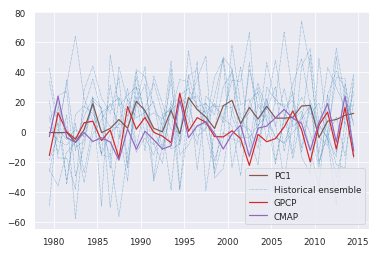

In [11]:
Plotting.time_plot(pc1,c="C5",label="PC"+str(eof_number+1))
[Plotting.time_plot(historical_projections[i],lw=.5,c="C0",ls=":") for i in range(10)]
Plotting.time_plot(historical_projections[10],lw=.5,c="C0",ls=":",label="Historical ensemble")
Plotting.time_plot(proj_gpcp,c=cm.tab10(.3),label="GPCP")
Plotting.time_plot(proj_cmap,c=cm.tab10(.4),label="CMAP")
plt.legend(loc=0)

# GPCP trends
The GPCP 1979-2014 trends...

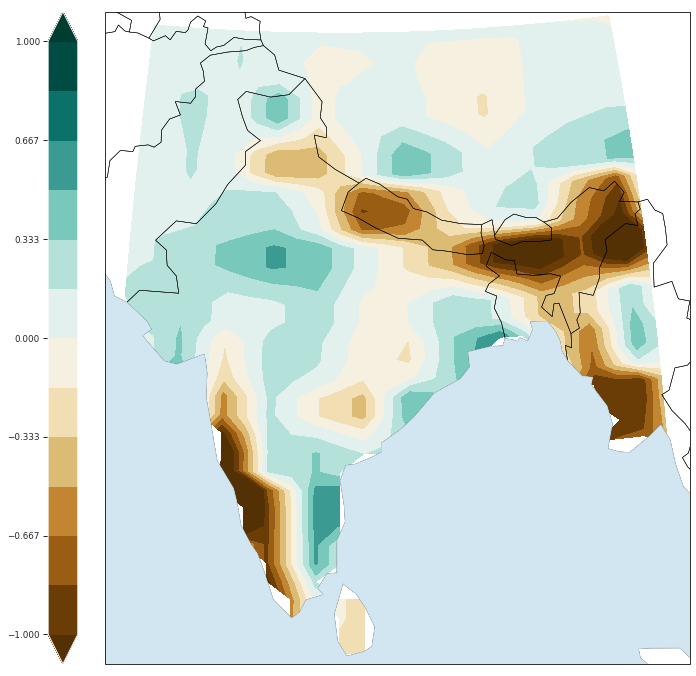

In [22]:
fig=meshplot_SAsia(cmip5.get_linear_trends(jja_gpcp(time=(start_date,stop_date))),nrow=1,ncol=1,axnum=1,vmin=-1,vmax=1)

# CMAP trends
... don't look a whole lot like the CMAP trends.

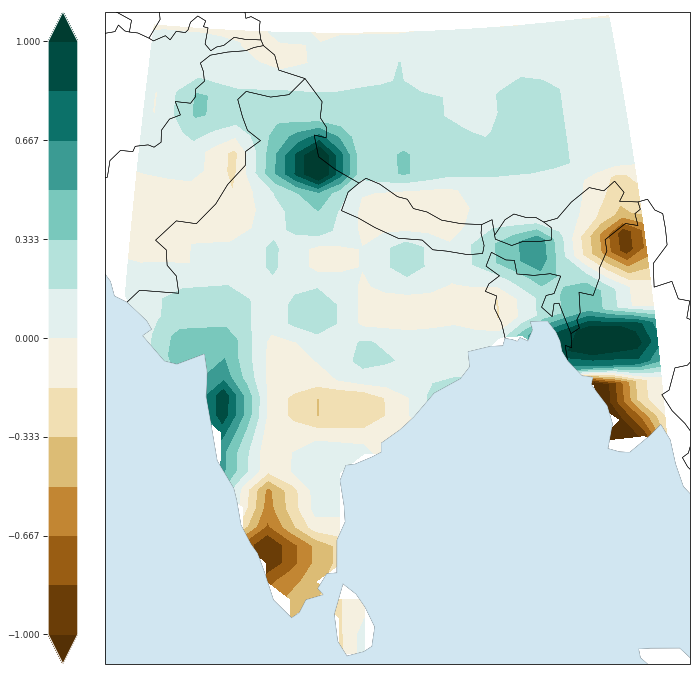

In [23]:
fig=meshplot_SAsia(cmip5.get_linear_trends(jja_cmap(time=(start_date,stop_date))),nrow=1,ncol=1,axnum=1,vmin=-1,vmax=1)